In [2]:
import sys
sys.path.append("..")

In [3]:
import rioxarray
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from src.utils import expand_grid

In [4]:
# Load template to start merging

template = rioxarray.open_rasterio(
    "/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif"
)

# Notice template is 1 for land and 0 for water
template_df = (
    template.rename({"x": "lon", "y": "lat"})
    .to_dataframe(name="id_template")
    .reset_index()
    .dropna()
)
template_df["grid_id"] = template_df.index

# Remove the water pixels
template_df = template_df[template_df.id_template == 1]

# Create grid for all years in the sample
template_expanded = expand_grid(
    {"grid_id": template_df.grid_id, "year": np.arange(2000, 2023)}
)

# Add lat and lon to the expanded grid
template_expanded = template_expanded.merge(
    template_df[["grid_id", "lat", "lon"]], on="grid_id"
)

# Load treatments and MTBS data
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather",
).drop(columns=["spatial_ref"])

# Merge with template to clean treatments (they're full of water!)
treatments = template_expanded.merge(treatments, on=["lat", "lon", "year"], how="left")

# Create treatments columns (both wildifre and prescribed are 1!)
treatments = treatments.assign(
    treat=np.select(
        [treatments["Event_ID"] == "nodata", treatments["Event_ID"].isna()],
        [0, 0],
        default=1,
    ),
)

### Load covariates

In [5]:
treats_wide = pd.pivot(treatments, index="grid_id", columns="year", values="treat")
treats_wide.columns = [f"treat_{col}" for col in treats_wide.columns]
treas_wide = treats_wide.reset_index()
treats_wide

,treat_2000,treat_2001,treat_2002,treat_2003,treat_2004,treat_2005,treat_2006,treat_2007,treat_2008,treat_2009,...,treat_2013,treat_2014,treat_2015,treat_2016,treat_2017,treat_2018,treat_2019,treat_2020,treat_2021,treat_2022
grid_id,,,,,,,,,,,,,,,,,,,,,
941,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
942,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
943,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966113,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966114,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


NameError: name 'data' is not defined

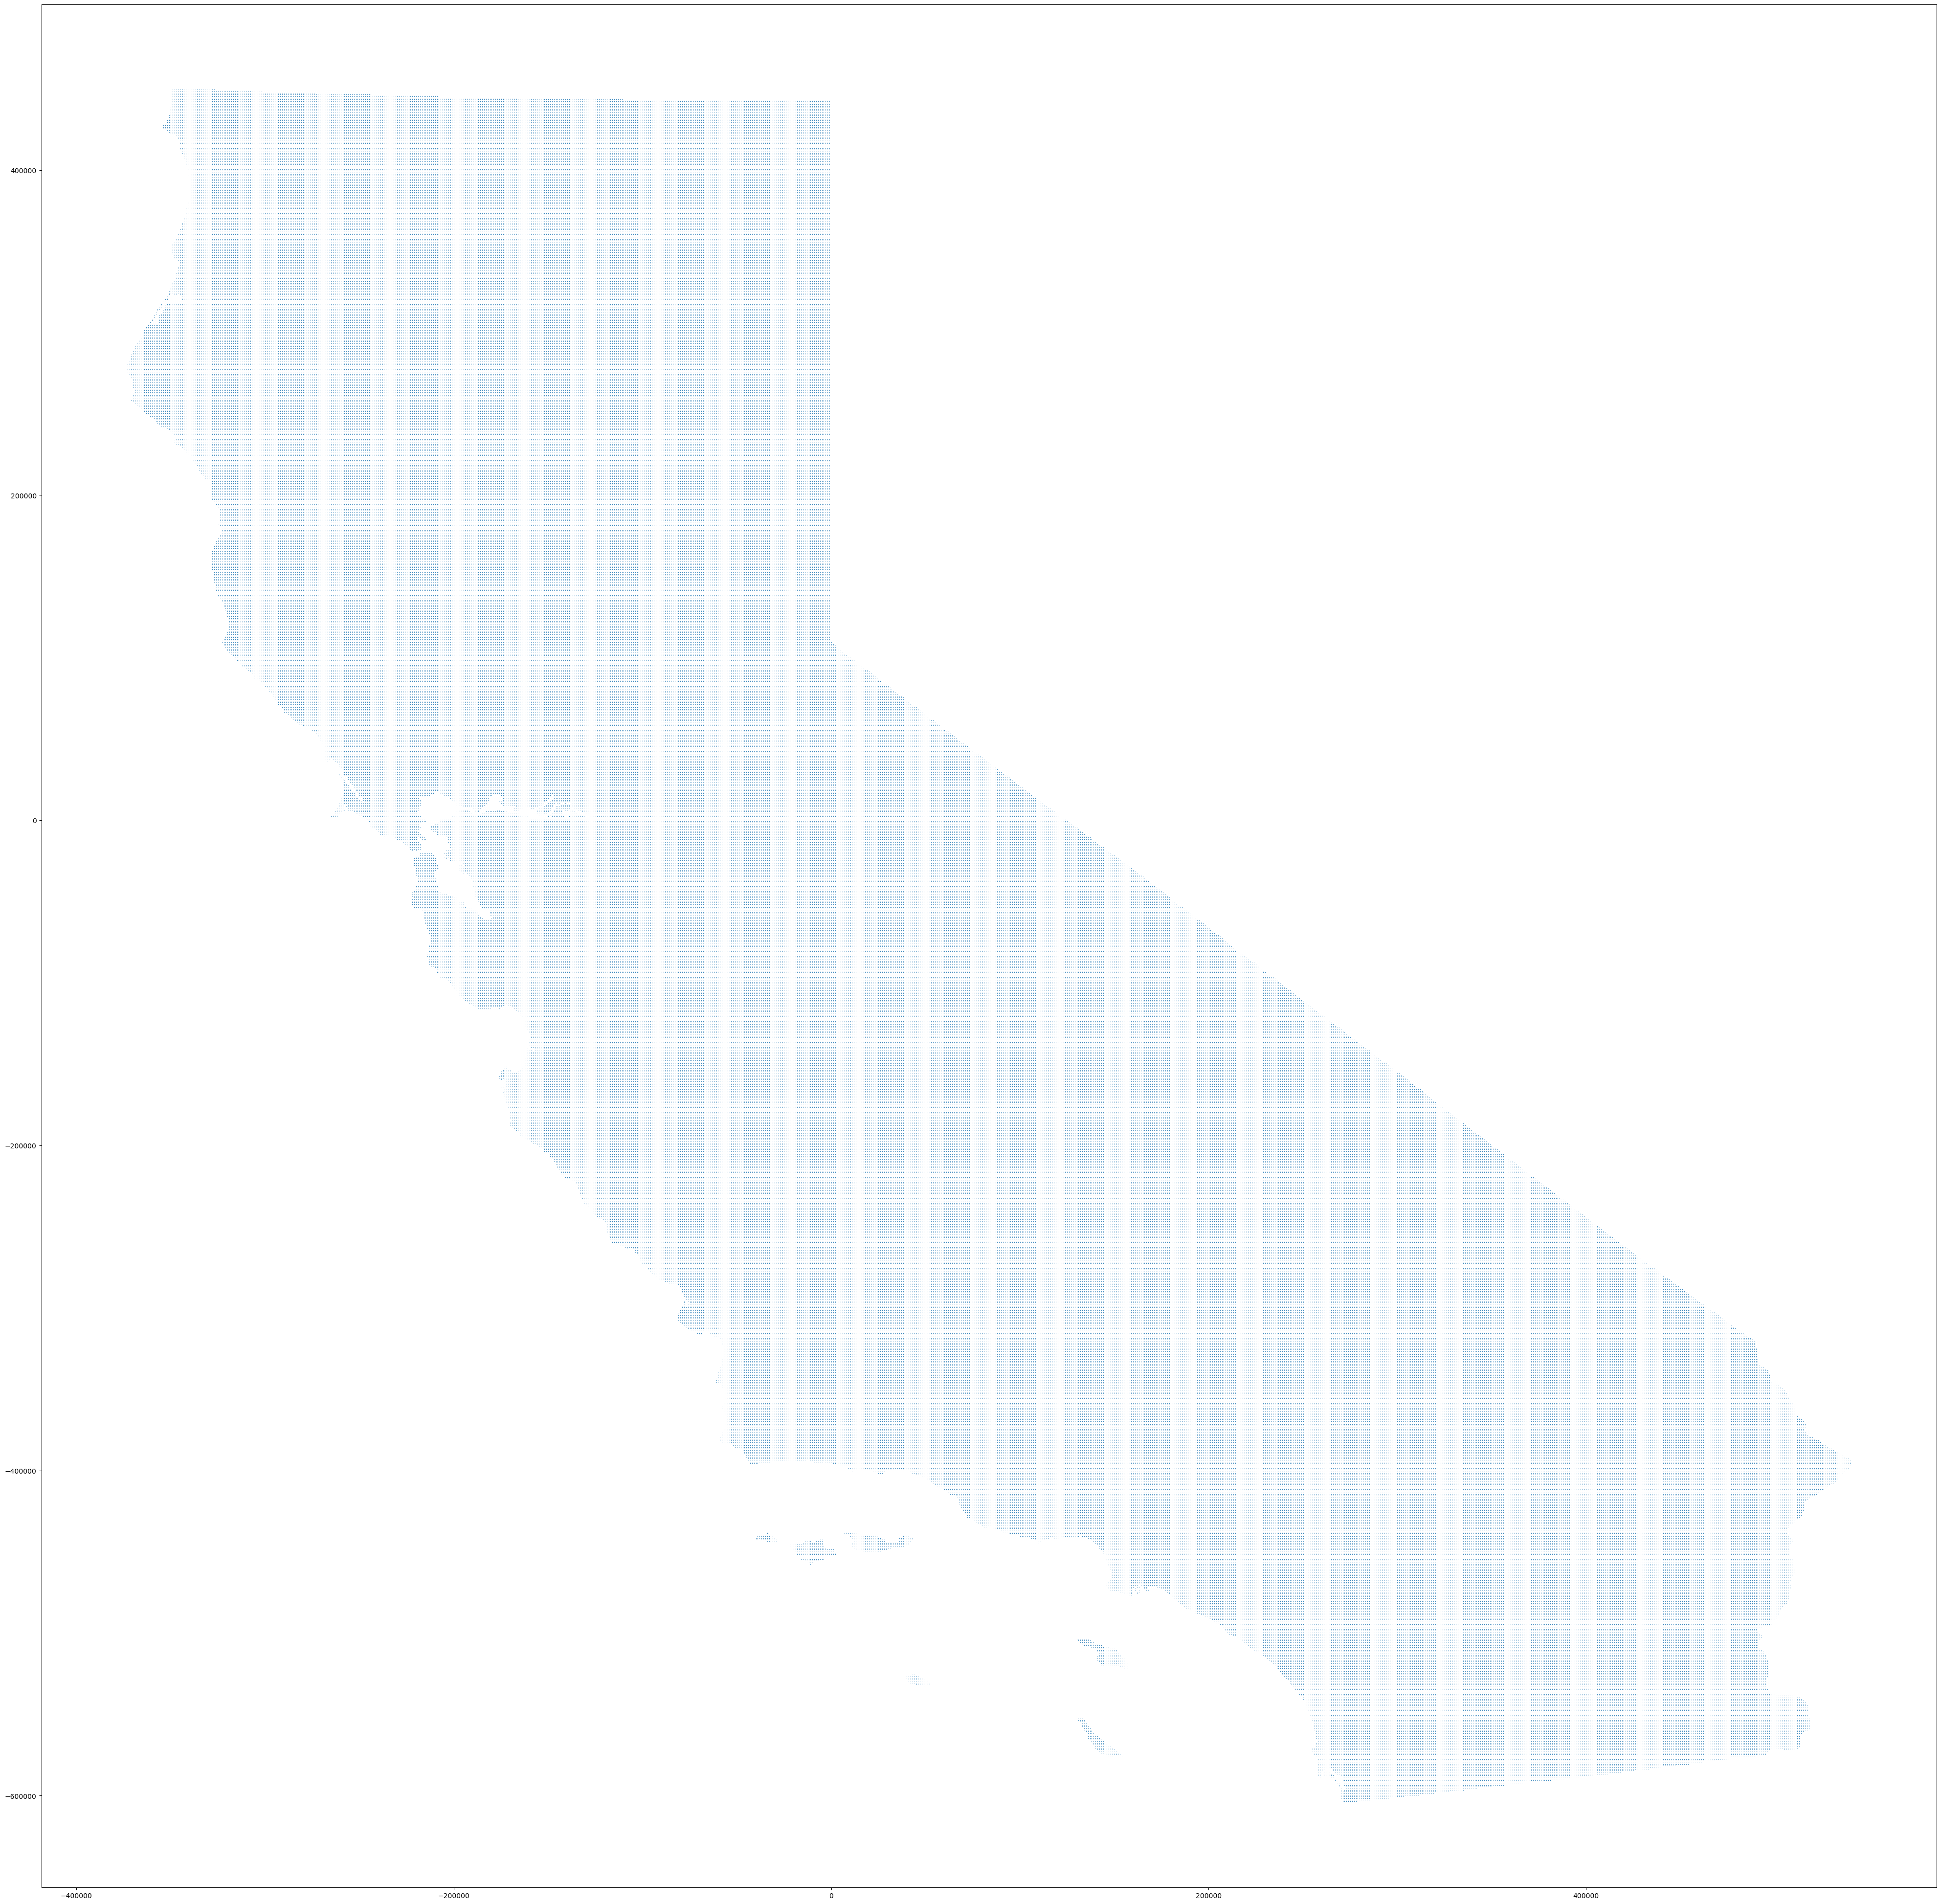

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(50, 50))
plt.plot(template_df.lon, template_df.lat, ",", alpha=0.9)
plt.plot(data[0].lon, data[0].lat, ",")

In [7]:
dict_paths = {
    "prism": "/mnt/sherlock/oak/prescribed_data/processed/prism.feather",
    "disturbances": "/mnt/sherlock/oak/prescribed_data/processed/disturbances.feather",
    "dem": "/mnt/sherlock/oak/prescribed_data/processed/dem.feather",
    "frp": "/mnt/sherlock/oak/prescribed_data/processed/frp_concat.feather",
}

# Load datasets and merge with template
data = []
for key, path in dict_paths.items():
    if key != "frp":
        df = pd.read_feather(path)
        df = df.drop(columns = ["lat", "lon"])
        data.append(df)

In [8]:
from functools import reduce
df = reduce(lambda x, y: x.merge(y, on='grid_id', how="left"), data)
df = df.merge(treas_wide, on="grid_id")

In [9]:
df

,tmin_1988_01,tmin_1988_02,tmin_1988_03,tmin_1988_04,tmin_1988_05,tmin_1988_06,tmin_1988_07,tmin_1988_08,tmin_1988_09,tmin_1988_10,...,treat_2013,treat_2014,treat_2015,treat_2016,treat_2017,treat_2018,treat_2019,treat_2020,treat_2021,treat_2022
0,7.567340,8.839235,10.208706,11.886081,13.451753,14.353240,18.000628,18.200863,16.801078,15.581539,...,0,0,0,0,0,0,0,0,0,0
1,7.386305,8.646471,10.020022,11.693062,13.282957,14.195154,17.876198,18.078473,16.639421,15.452010,...,0,0,0,0,0,0,0,0,0,0
2,7.205270,8.453707,9.831338,11.500043,13.114162,14.037067,17.751768,17.956084,16.477765,15.322481,...,0,0,0,0,0,0,0,0,0,0
3,7.024235,8.260943,9.642654,11.307024,12.945366,13.878981,17.627339,17.833694,16.316108,15.192952,...,0,0,0,0,0,0,0,0,0,0
4,6.942066,8.168091,9.547778,11.240595,12.892000,13.833011,17.587476,17.794826,16.266569,15.140841,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406718,0.253392,2.746646,1.034052,3.924154,3.944022,7.219834,10.781526,9.899816,8.864880,8.386296,...,0,0,0,0,0,0,0,0,0,0
406719,-0.184423,2.467034,0.796014,3.681509,3.670215,6.966671,10.701724,9.778495,8.590633,8.020198,...,0,0,0,0,0,0,0,0,0,0
406720,-0.396410,2.075984,0.620706,3.536526,3.577218,6.883493,10.463744,9.451273,8.034960,7.502071,...,0,0,0,0,0,0,0,0,0,0
406721,-0.608397,1.684934,0.445397,3.391543,3.484221,6.800315,10.225764,9.124050,7.479288,6.983944,...,0,0,0,0,0,0,0,0,0,0


### Test balancing

In [10]:
# Focal year 2008
import re
cols_remove = [col for col in df.columns.tolist() if 
    re.search(r"\d+", col) and int(re.findall(r"\d+", col)[0]) < 2000]
df_subset = df.drop(columns=cols_remove)
del(df)

In [23]:
# Focal year 2008
cols_remove = [col for col in df_subset.columns.tolist() if 
    re.search(r"\d+", col) and int(re.findall(r"\d+", col)[0]) > 2008]
df_subset = df_subset.drop(columns=cols_remove)

df_subset = df_subset.dropna()

In [24]:
w = df_subset.treat_2008.values
X = df_subset.drop(columns=[col for col in df_subset.columns if "treat" in col]).values
X = MinMaxScaler().fit_transform(X)

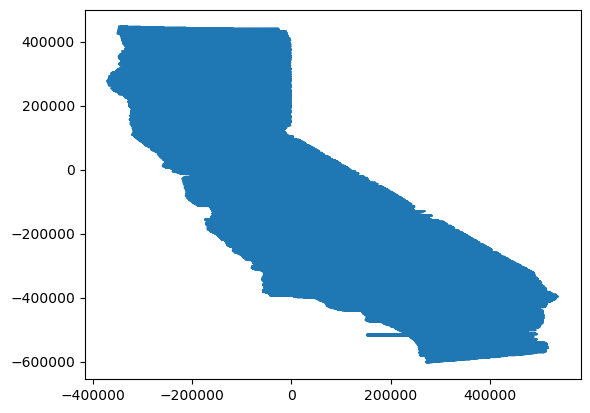

In [58]:
plt.plot(
template_df[template_df.grid_id.isin(df_subset["grid_id"].tolist())]["lon"],
template_df[template_df.grid_id.isin(df_subset["grid_id"].tolist())]["lat"],
)
# plt.plot(
#     template_df.lon,
#     template_df.lat,
# )


In [59]:
df_subset

,tmin_2000_01,tmin_2000_02,tmin_2000_03,tmin_2000_04,tmin_2000_05,tmin_2000_06,tmin_2000_07,tmin_2000_08,tmin_2000_09,tmin_2000_10,...,aspect,treat_2000,treat_2001,treat_2002,treat_2003,treat_2004,treat_2005,treat_2006,treat_2007,treat_2008
9,8.675816,10.219345,9.731707,12.180506,14.490682,16.230926,16.913616,18.413110,16.969744,14.131212,...,316.839905,0,0,0,0,0,0,0,0,0
12,8.144152,9.759753,9.178896,11.747844,14.075211,15.906640,16.531920,18.077907,16.631799,13.807841,...,5.109946,0,0,0,0,0,0,0,0,0
13,8.105558,9.720821,9.159455,11.721721,14.078178,15.900729,16.500637,18.065376,16.612883,13.788348,...,18.281784,0,0,0,0,0,0,0,0,0
25,8.489559,10.073552,9.580560,12.055531,14.382141,16.145022,16.830786,18.314841,16.877583,14.013923,...,328.015411,0,0,0,0,0,0,0,0,0
26,8.286108,9.899659,9.365999,11.886550,14.214337,16.018683,16.688502,18.184488,16.742595,13.885365,...,352.953552,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406708,3.598752,5.177238,3.126388,6.295009,7.461285,10.657983,10.246043,10.319505,10.910593,7.972889,...,345.271362,0,0,0,0,0,0,0,0,0
406709,3.487103,5.089485,3.086833,6.248275,7.419530,10.689158,10.229421,10.338321,10.888590,7.902169,...,300.836426,0,0,0,0,0,0,0,0,0
406710,3.392084,5.045586,3.030515,6.185314,7.390649,10.612912,10.319819,10.342653,10.801947,7.777403,...,280.484711,0,0,0,0,0,0,0,0,0
406713,3.009395,4.720792,2.778185,5.897559,7.162360,10.498544,10.369092,10.331163,10.551315,7.452385,...,17.305172,0,0,0,0,0,0,0,0,0


In [35]:
from src.cbps_torch import CBPS

cbps = CBPS(
    X=X,
    W=w,
    estimand="ATT",
    intercept=True,
    noi=True,
    niter=10_000,
    lr=1e-5,
    reg=1e-5,
    svd=None,
)
weights = cbps.weights(numpy=True)

Optimizing CBPS...:   0%|          | 12/10000 [00:00<03:09, 52.78it/s]

Iteration 0: loss = 23.11890983581543


Optimizing CBPS...:   1%|          | 122/10000 [00:01<01:33, 106.05it/s]

Iteration 100: loss = 22.810710906982422


Optimizing CBPS...:   2%|▏         | 221/10000 [00:02<01:31, 106.81it/s]

Iteration 200: loss = 22.50250816345215


Optimizing CBPS...:   3%|▎         | 320/10000 [00:03<01:30, 107.31it/s]

Iteration 300: loss = 22.194303512573242


Optimizing CBPS...:   4%|▍         | 419/10000 [00:04<01:29, 107.26it/s]

Iteration 400: loss = 21.886104583740234


Optimizing CBPS...:   5%|▌         | 518/10000 [00:04<01:28, 107.26it/s]

Iteration 500: loss = 21.57790756225586


Optimizing CBPS...:   6%|▌         | 617/10000 [00:05<01:27, 107.24it/s]

Iteration 600: loss = 21.269710540771484


Optimizing CBPS...:   7%|▋         | 716/10000 [00:06<01:26, 107.35it/s]

Iteration 700: loss = 20.961515426635742


Optimizing CBPS...:   8%|▊         | 815/10000 [00:07<01:25, 107.20it/s]

Iteration 800: loss = 20.653318405151367


Optimizing CBPS...:   9%|▉         | 914/10000 [00:08<01:24, 107.19it/s]

Iteration 900: loss = 20.345125198364258


Optimizing CBPS...:  10%|█         | 1013/10000 [00:09<01:23, 107.19it/s]

Iteration 1000: loss = 20.03693389892578


Optimizing CBPS...:  11%|█         | 1112/10000 [00:10<01:22, 107.24it/s]

Iteration 1100: loss = 19.72874641418457


Optimizing CBPS...:  12%|█▏        | 1222/10000 [00:11<01:21, 107.23it/s]

Iteration 1200: loss = 19.420562744140625


Optimizing CBPS...:  13%|█▎        | 1321/10000 [00:12<01:20, 107.20it/s]

Iteration 1300: loss = 19.112380981445312


Optimizing CBPS...:  14%|█▍        | 1420/10000 [00:13<01:20, 107.14it/s]

Iteration 1400: loss = 18.804201126098633


Optimizing CBPS...:  15%|█▌        | 1519/10000 [00:14<01:19, 107.18it/s]

Iteration 1500: loss = 18.496028900146484


Optimizing CBPS...:  16%|█▌        | 1618/10000 [00:15<01:18, 107.31it/s]

Iteration 1600: loss = 18.1878604888916


Optimizing CBPS...:  17%|█▋        | 1717/10000 [00:16<01:17, 107.28it/s]

Iteration 1700: loss = 17.87969970703125


Optimizing CBPS...:  18%|█▊        | 1816/10000 [00:17<01:16, 107.30it/s]

Iteration 1800: loss = 17.57154655456543


Optimizing CBPS...:  19%|█▉        | 1915/10000 [00:18<01:15, 107.13it/s]

Iteration 1900: loss = 17.263408660888672


Optimizing CBPS...:  20%|██        | 2014/10000 [00:18<01:14, 107.11it/s]

Iteration 2000: loss = 16.955278396606445


Optimizing CBPS...:  21%|██        | 2113/10000 [00:19<01:13, 107.15it/s]

Iteration 2100: loss = 16.647171020507812


Optimizing CBPS...:  22%|██▏       | 2212/10000 [00:20<01:12, 106.98it/s]

Iteration 2200: loss = 16.339075088500977


Optimizing CBPS...:  23%|██▎       | 2322/10000 [00:21<01:11, 107.07it/s]

Iteration 2300: loss = 16.030996322631836


Optimizing CBPS...:  24%|██▍       | 2421/10000 [00:22<01:11, 106.73it/s]

Iteration 2400: loss = 15.722939491271973


Optimizing CBPS...:  25%|██▌       | 2520/10000 [00:23<01:10, 106.68it/s]

Iteration 2500: loss = 15.414925575256348


Optimizing CBPS...:  26%|██▌       | 2619/10000 [00:24<01:09, 106.85it/s]

Iteration 2600: loss = 15.106982231140137


Optimizing CBPS...:  27%|██▋       | 2718/10000 [00:25<01:08, 106.70it/s]

Iteration 2700: loss = 14.799077987670898


Optimizing CBPS...:  28%|██▊       | 2817/10000 [00:26<01:07, 106.78it/s]

Iteration 2800: loss = 14.491196632385254


Optimizing CBPS...:  29%|██▉       | 2916/10000 [00:27<01:06, 106.73it/s]

Iteration 2900: loss = 14.183340072631836


Optimizing CBPS...:  30%|███       | 3015/10000 [00:28<01:05, 106.53it/s]

Iteration 3000: loss = 13.875511169433594


Optimizing CBPS...:  31%|███       | 3114/10000 [00:29<01:04, 106.67it/s]

Iteration 3100: loss = 13.567720413208008


Optimizing CBPS...:  32%|███▏      | 3213/10000 [00:30<01:03, 106.61it/s]

Iteration 3200: loss = 13.259977340698242


Optimizing CBPS...:  33%|███▎      | 3312/10000 [00:31<01:02, 106.50it/s]

Iteration 3300: loss = 12.952285766601562


Optimizing CBPS...:  34%|███▍      | 3422/10000 [00:32<01:01, 106.68it/s]

Iteration 3400: loss = 12.644662857055664


Optimizing CBPS...:  35%|███▌      | 3521/10000 [00:33<01:00, 106.84it/s]

Iteration 3500: loss = 12.33712387084961


Optimizing CBPS...:  36%|███▌      | 3620/10000 [00:33<00:59, 106.69it/s]

Iteration 3600: loss = 12.02969741821289


Optimizing CBPS...:  37%|███▋      | 3719/10000 [00:34<00:58, 106.71it/s]

Iteration 3700: loss = 11.722420692443848


Optimizing CBPS...:  38%|███▊      | 3818/10000 [00:35<00:57, 106.84it/s]

Iteration 3800: loss = 11.415334701538086


Optimizing CBPS...:  39%|███▉      | 3917/10000 [00:36<00:56, 106.77it/s]

Iteration 3900: loss = 11.108637809753418


Optimizing CBPS...:  40%|████      | 4016/10000 [00:37<00:56, 106.67it/s]

Iteration 4000: loss = 10.802377700805664


Optimizing CBPS...:  41%|████      | 4115/10000 [00:38<00:55, 106.71it/s]

Iteration 4100: loss = 10.496451377868652


Optimizing CBPS...:  42%|████▏     | 4214/10000 [00:39<00:54, 106.70it/s]

Iteration 4200: loss = 10.191012382507324


Optimizing CBPS...:  43%|████▎     | 4313/10000 [00:40<00:53, 106.75it/s]

Iteration 4300: loss = 9.886276245117188


Optimizing CBPS...:  44%|████▍     | 4412/10000 [00:41<00:52, 106.64it/s]

Iteration 4400: loss = 9.582870483398438


Optimizing CBPS...:  45%|████▌     | 4522/10000 [00:42<00:51, 106.68it/s]

Iteration 4500: loss = 9.28050708770752


Optimizing CBPS...:  46%|████▌     | 4621/10000 [00:43<00:50, 106.61it/s]

Iteration 4600: loss = 8.979632377624512


Optimizing CBPS...:  47%|████▋     | 4720/10000 [00:44<00:49, 106.64it/s]

Iteration 4700: loss = 8.680587768554688


Optimizing CBPS...:  48%|████▊     | 4819/10000 [00:45<00:48, 106.59it/s]

Iteration 4800: loss = 8.38415241241455


Optimizing CBPS...:  49%|████▉     | 4918/10000 [00:46<00:47, 106.62it/s]

Iteration 4900: loss = 8.091296195983887


Optimizing CBPS...:  50%|█████     | 5017/10000 [00:47<00:46, 106.61it/s]

Iteration 5000: loss = 7.802567005157471


Optimizing CBPS...:  51%|█████     | 5116/10000 [00:48<00:45, 106.54it/s]

Iteration 5100: loss = 7.519818305969238


Optimizing CBPS...:  52%|█████▏    | 5215/10000 [00:48<00:44, 106.58it/s]

Iteration 5200: loss = 7.2447404861450195


Optimizing CBPS...:  53%|█████▎    | 5314/10000 [00:49<00:43, 106.51it/s]

Iteration 5300: loss = 6.97959566116333


Optimizing CBPS...:  54%|█████▍    | 5413/10000 [00:50<00:43, 106.57it/s]

Iteration 5400: loss = 6.727217674255371


Optimizing CBPS...:  55%|█████▌    | 5512/10000 [00:51<00:42, 106.56it/s]

Iteration 5500: loss = 6.491003513336182


Optimizing CBPS...:  56%|█████▌    | 5622/10000 [00:52<00:41, 106.39it/s]

Iteration 5600: loss = 6.274708271026611


Optimizing CBPS...:  57%|█████▋    | 5721/10000 [00:53<00:40, 106.49it/s]

Iteration 5700: loss = 6.082194805145264


Optimizing CBPS...:  58%|█████▊    | 5820/10000 [00:54<00:39, 106.55it/s]

Iteration 5800: loss = 5.916855335235596


Optimizing CBPS...:  59%|█████▉    | 5919/10000 [00:55<00:38, 106.51it/s]

Iteration 5900: loss = 5.780903339385986


Optimizing CBPS...:  60%|██████    | 6018/10000 [00:56<00:37, 106.35it/s]

Iteration 6000: loss = 5.674607276916504


Optimizing CBPS...:  61%|██████    | 6117/10000 [00:57<00:36, 106.29it/s]

Iteration 6100: loss = 5.595837116241455


Optimizing CBPS...:  62%|██████▏   | 6216/10000 [00:58<00:35, 106.16it/s]

Iteration 6200: loss = 5.540249824523926


Optimizing CBPS...:  63%|██████▎   | 6315/10000 [00:59<00:34, 106.20it/s]

Iteration 6300: loss = 5.502181529998779


Optimizing CBPS...:  64%|██████▍   | 6414/10000 [01:00<00:33, 106.38it/s]

Iteration 6400: loss = 5.475917339324951


Optimizing CBPS...:  65%|██████▌   | 6513/10000 [01:01<00:32, 106.50it/s]

Iteration 6500: loss = 5.456734657287598


Optimizing CBPS...:  66%|██████▌   | 6612/10000 [01:02<00:31, 106.51it/s]

Iteration 6600: loss = 5.441335678100586


Optimizing CBPS...:  67%|██████▋   | 6722/10000 [01:03<00:30, 106.41it/s]

Iteration 6700: loss = 5.427740097045898


Optimizing CBPS...:  68%|██████▊   | 6821/10000 [01:04<00:29, 106.34it/s]

Iteration 6800: loss = 5.4148969650268555


Optimizing CBPS...:  69%|██████▉   | 6920/10000 [01:04<00:28, 106.42it/s]

Iteration 6900: loss = 5.402297019958496


Optimizing CBPS...:  70%|███████   | 7019/10000 [01:05<00:28, 106.43it/s]

Iteration 7000: loss = 5.389720916748047


Optimizing CBPS...:  71%|███████   | 7118/10000 [01:06<00:27, 106.40it/s]

Iteration 7100: loss = 5.377082824707031


Optimizing CBPS...:  72%|███████▏  | 7217/10000 [01:07<00:26, 106.40it/s]

Iteration 7200: loss = 5.364340305328369


Optimizing CBPS...:  73%|███████▎  | 7316/10000 [01:08<00:25, 106.47it/s]

Iteration 7300: loss = 5.3514838218688965


Optimizing CBPS...:  74%|███████▍  | 7415/10000 [01:09<00:24, 106.42it/s]

Iteration 7400: loss = 5.338512897491455


Optimizing CBPS...:  75%|███████▌  | 7514/10000 [01:10<00:23, 106.43it/s]

Iteration 7500: loss = 5.325432777404785


Optimizing CBPS...:  76%|███████▌  | 7613/10000 [01:11<00:22, 106.46it/s]

Iteration 7600: loss = 5.3122453689575195


Optimizing CBPS...:  77%|███████▋  | 7712/10000 [01:12<00:21, 106.43it/s]

Iteration 7700: loss = 5.29896354675293


Optimizing CBPS...:  78%|███████▊  | 7822/10000 [01:13<00:20, 106.52it/s]

Iteration 7800: loss = 5.285593032836914


Optimizing CBPS...:  79%|███████▉  | 7921/10000 [01:14<00:19, 106.36it/s]

Iteration 7900: loss = 5.272145748138428


Optimizing CBPS...:  80%|████████  | 8020/10000 [01:15<00:18, 106.41it/s]

Iteration 8000: loss = 5.258636474609375


Optimizing CBPS...:  81%|████████  | 8119/10000 [01:16<00:17, 106.47it/s]

Iteration 8100: loss = 5.245069980621338


Optimizing CBPS...:  82%|████████▏ | 8218/10000 [01:17<00:16, 106.32it/s]

Iteration 8200: loss = 5.231465816497803


Optimizing CBPS...:  83%|████████▎ | 8317/10000 [01:18<00:15, 106.50it/s]

Iteration 8300: loss = 5.217829704284668


Optimizing CBPS...:  84%|████████▍ | 8416/10000 [01:19<00:14, 106.36it/s]

Iteration 8400: loss = 5.20417594909668


Optimizing CBPS...:  85%|████████▌ | 8515/10000 [01:19<00:13, 106.48it/s]

Iteration 8500: loss = 5.190516471862793


Optimizing CBPS...:  86%|████████▌ | 8614/10000 [01:20<00:13, 106.40it/s]

Iteration 8600: loss = 5.176867485046387


Optimizing CBPS...:  87%|████████▋ | 8713/10000 [01:21<00:12, 106.37it/s]

Iteration 8700: loss = 5.163237571716309


Optimizing CBPS...:  88%|████████▊ | 8812/10000 [01:22<00:11, 106.43it/s]

Iteration 8800: loss = 5.149633407592773


Optimizing CBPS...:  89%|████████▉ | 8922/10000 [01:23<00:10, 106.42it/s]

Iteration 8900: loss = 5.136078834533691


Optimizing CBPS...:  90%|█████████ | 9021/10000 [01:24<00:09, 106.38it/s]

Iteration 9000: loss = 5.122570514678955


Optimizing CBPS...:  91%|█████████ | 9120/10000 [01:25<00:08, 106.44it/s]

Iteration 9100: loss = 5.109128475189209


Optimizing CBPS...:  92%|█████████▏| 9219/10000 [01:26<00:07, 106.39it/s]

Iteration 9200: loss = 5.095752716064453


Optimizing CBPS...:  93%|█████████▎| 9318/10000 [01:27<00:06, 106.58it/s]

Iteration 9300: loss = 5.082458972930908


Optimizing CBPS...:  94%|█████████▍| 9417/10000 [01:28<00:05, 106.32it/s]

Iteration 9400: loss = 5.069253444671631


Optimizing CBPS...:  95%|█████████▌| 9516/10000 [01:29<00:04, 106.45it/s]

Iteration 9500: loss = 5.056141376495361


Optimizing CBPS...:  96%|█████████▌| 9615/10000 [01:30<00:03, 106.30it/s]

Iteration 9600: loss = 5.04312801361084


Optimizing CBPS...:  97%|█████████▋| 9714/10000 [01:31<00:02, 106.30it/s]

Iteration 9700: loss = 5.030220985412598


Optimizing CBPS...:  98%|█████████▊| 9813/10000 [01:32<00:01, 106.42it/s]

Iteration 9800: loss = 5.017427444458008


Optimizing CBPS...:  99%|█████████▉| 9912/10000 [01:33<00:00, 106.39it/s]

Iteration 9900: loss = 5.004751682281494


Optimizing CBPS...: 100%|██████████| 10000/10000 [01:33<00:00, 106.46it/s]


In [60]:
weights.shape

(205448,)